In [8]:
import warnings
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from metpy.plots import ctables
from cartopy.feature import ShapelyFeature,NaturalEarthFeature
import cartopy.feature as cfeature



In [ ]:
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest("radar")
available_locs = DataAccessLayer.getAvailableLocationNames(request)
available_locs.sort()
#print(list(available_locs))
request.setLocationNames("kgld")
availableParms = DataAccessLayer.getAvailableParameters(request)
availableParms.sort()
#list(availableParms)

productIDs = DataAccessLayer.getRadarProductIDs(availableParms)
productNames = DataAccessLayer.getRadarProductNames(availableParms)
print(productIDs)
print(productNames)

In [6]:
mycmap = ctables.registry.get_colortable("NWSReflectivity")


Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_230_360_0.0_359.0
Prod : Digital Hybrid Scan Refl
Range: -27.0  to  62.5  (Unit : dBZ )
Size : (230, 360)



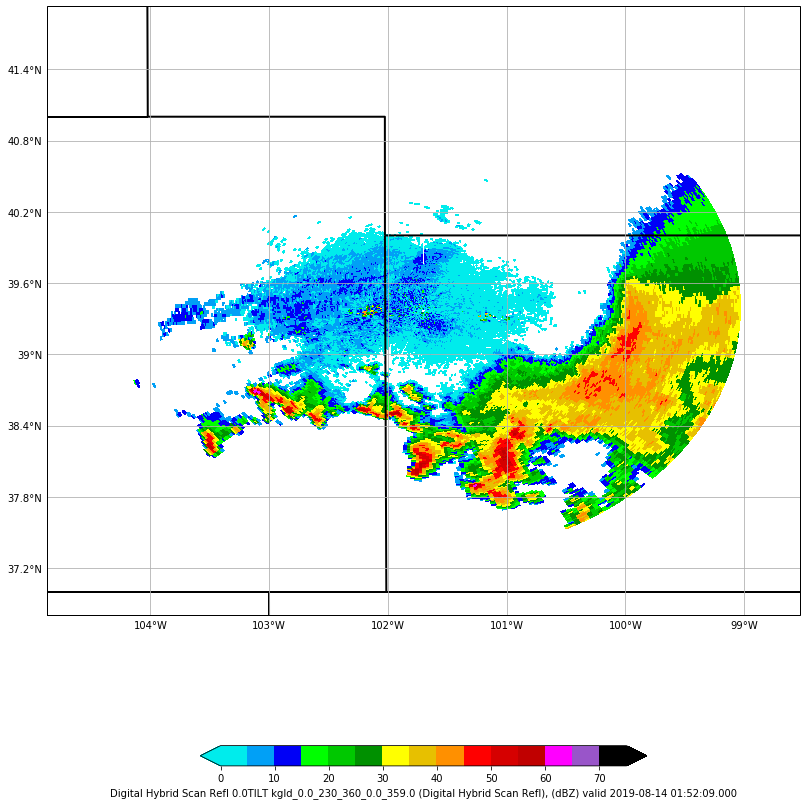


Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_920_360_0.0_359.0
Prod : Digital Inst Precip Rate
Range: 7.0555557e-09  to  3.4318222e-05  (Unit : m*sec^-1 )
Size : (920, 360)



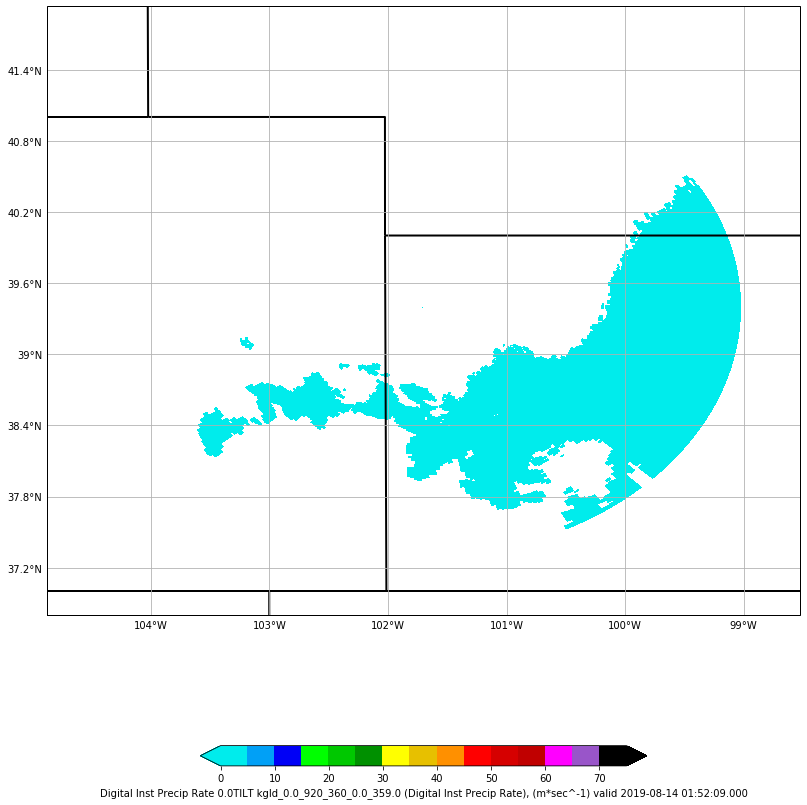


Recs :  1
Time : 2019-08-14 01:46:41
Name : kgld_0.0_460_360_0.0_359.0
Prod : Digital Vert Integ Liq
Range: 0.0  to  79.53568  (Unit : kg*m^-2 )
Size : (460, 360)



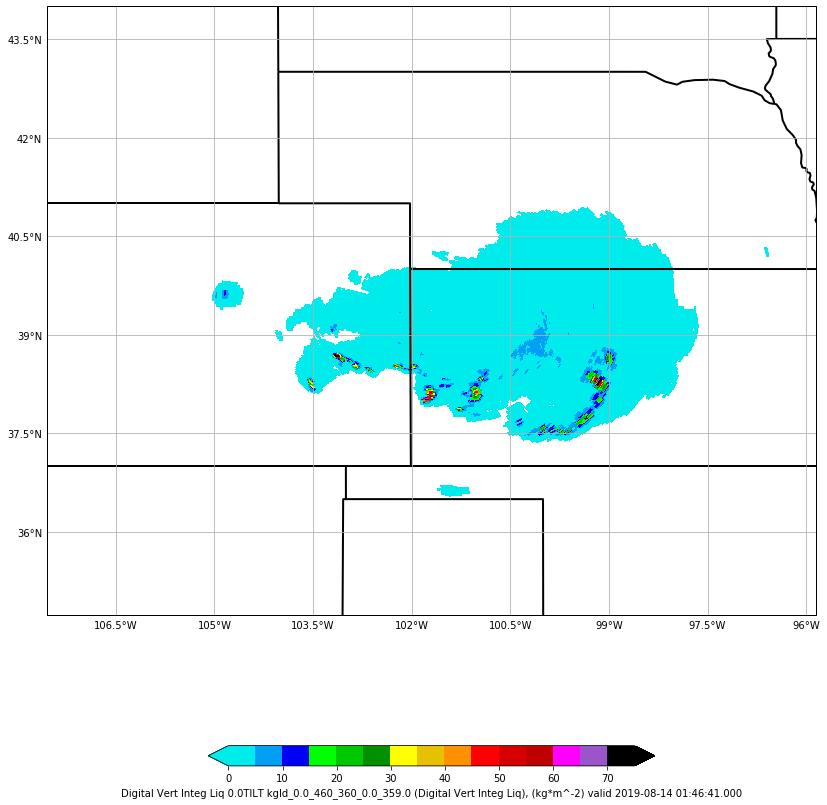


Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_920_360_0.0_359.0
Prod : Hybrid Hydrometeor Class
Range: 1.0  to  14.0  (Unit : count )
Size : (920, 360)



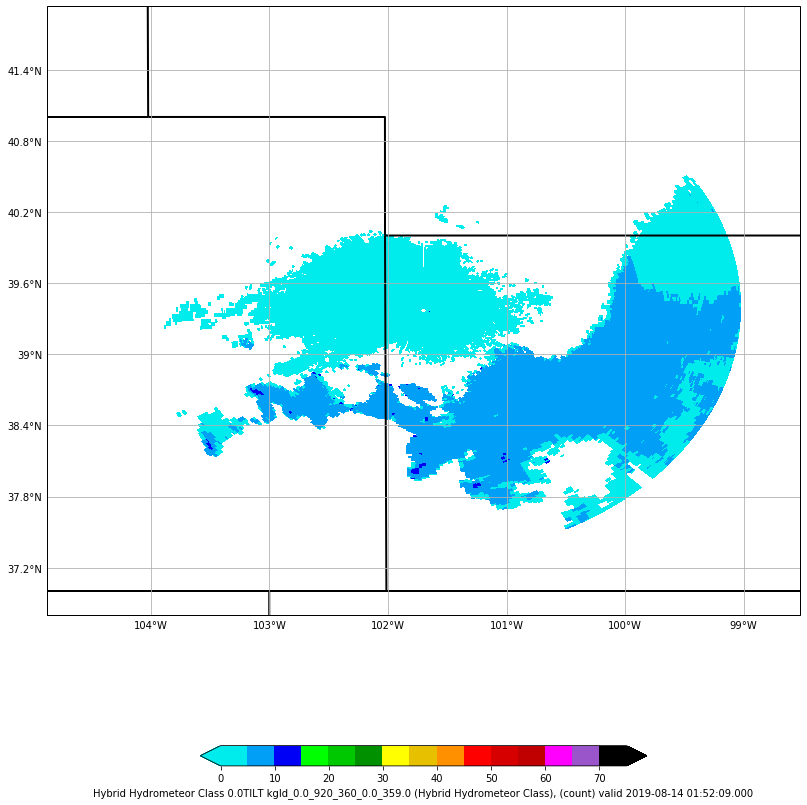


Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_115_360_359.0_359.0
Prod : One Hour Accum
Range: 0.0  to  0.0508  (Unit : m )
Size : (115, 360)



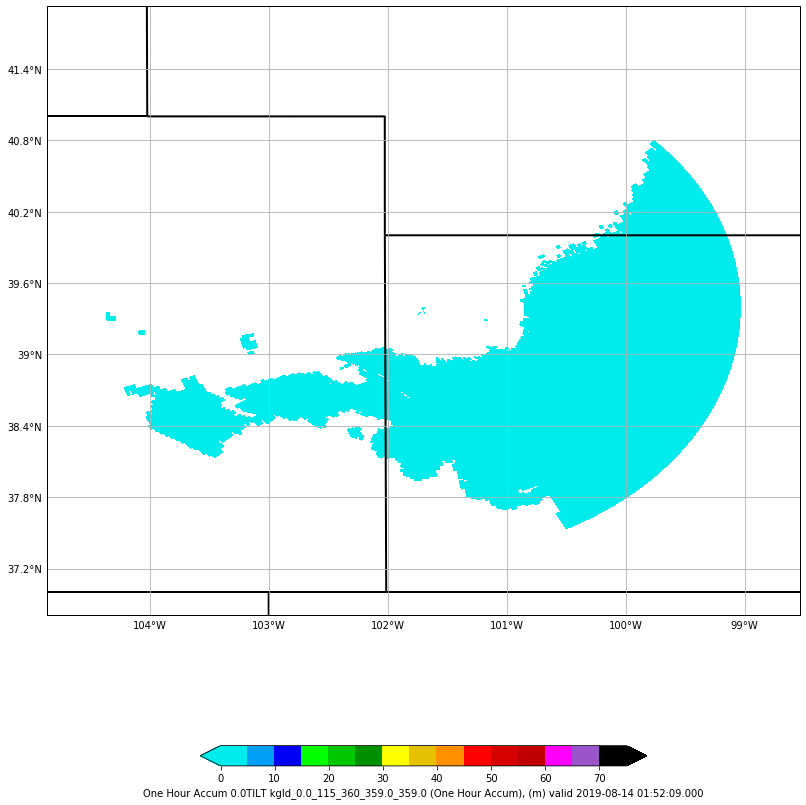


Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_115_360_359.0_359.0
Prod : One Hour Precip
Range: 0.0  to  0.1016  (Unit : m )
Size : (115, 360)



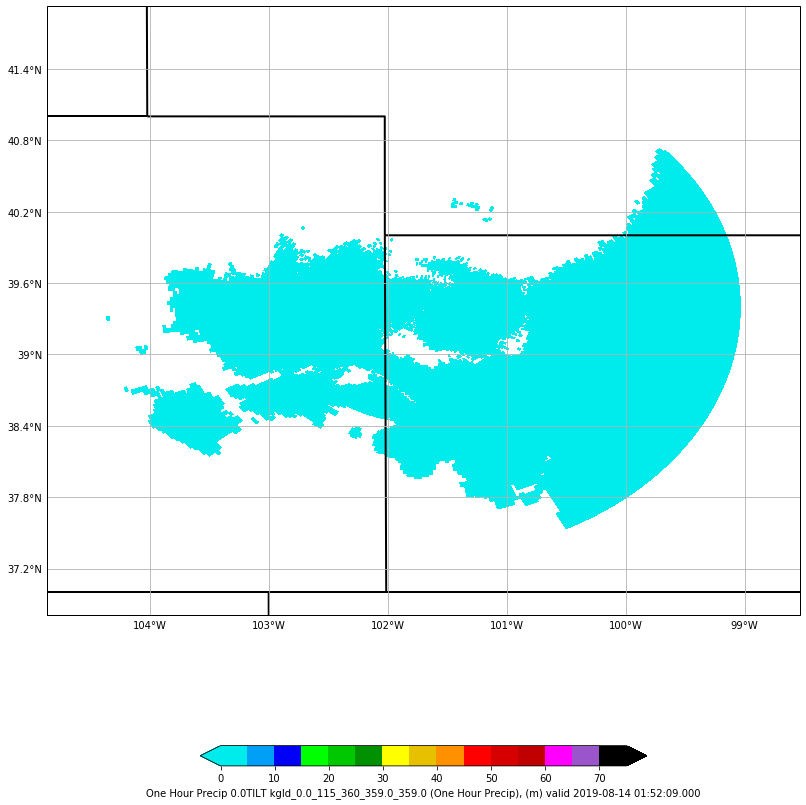


Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_920_360_0.0_359.0
Prod : One Hour Unbiased Accum
Range: 2.5400002e-05  to  0.06477  (Unit : m )
Size : (920, 360)



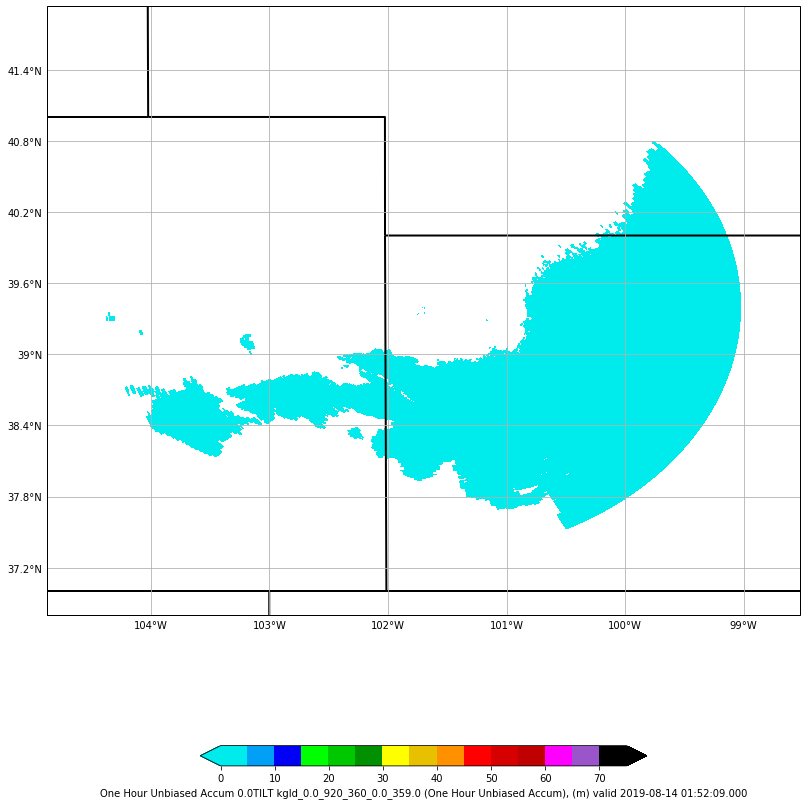

No levels found for Reflectivity
No levels found for Storm Rel Velocity

Recs :  1
Time : 2019-08-14 01:52:09
Name : kgld_0.0_920_360_0.0_359.0
Prod : Storm Total Accum
Range: 0.000508  to  0.1143  (Unit : m )
Size : (920, 360)



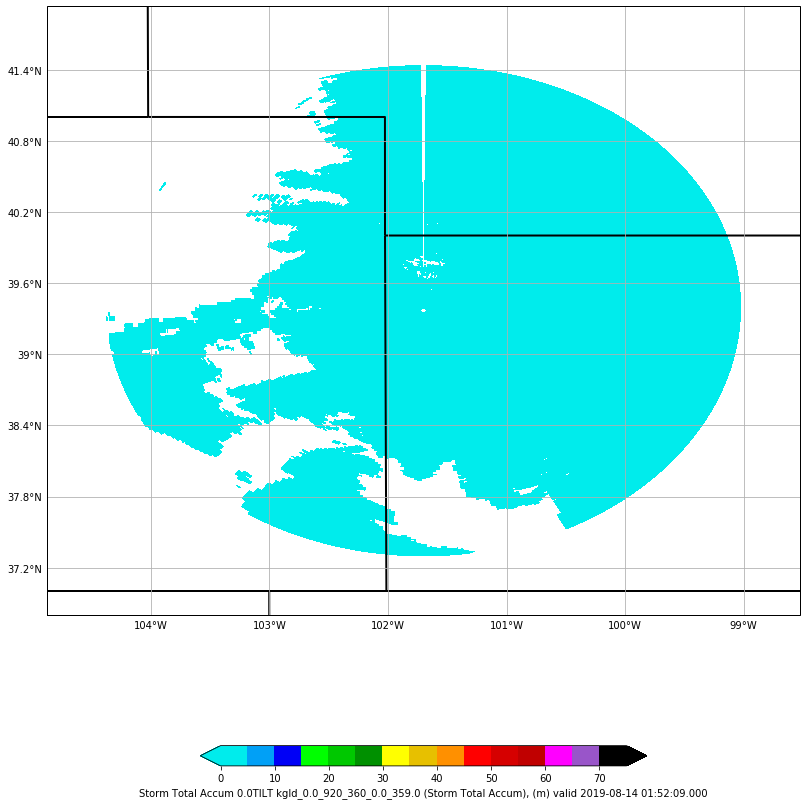


Recs :  2
Time : 2019-08-14 01:52:09
Name : kgld_0.0_116_360_0.0_359.0
Prod : Storm Total Precip
Range: 0.0  to  1.749552  (Unit : m )
Size : (116, 360)



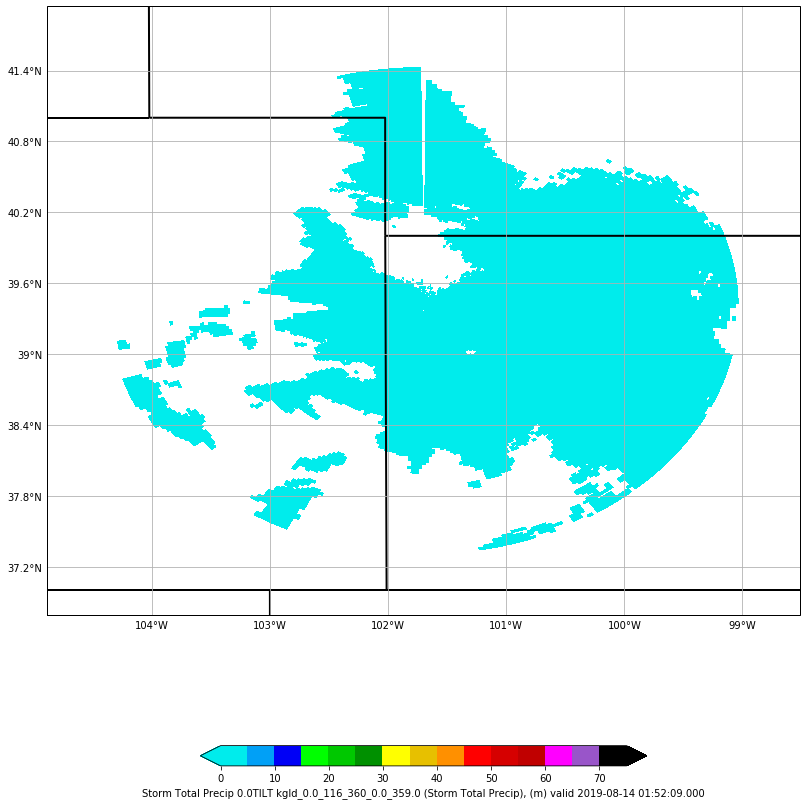

No levels found for Velocity


In [9]:
warnings.filterwarnings("ignore",category =RuntimeWarning)

def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 16),
                           subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # Plot political/state boundaries handled by Cartopy
    political_boundaries = NaturalEarthFeature(category='cultural',
                                   name='admin_0_boundary_lines_land',
                                   scale='50m', facecolor='none')
    states = NaturalEarthFeature(category='cultural',
                                   name='admin_1_states_provinces_lines',
                                   scale='50m', facecolor='none')
    ax.add_feature(political_boundaries, linestyle='-', edgecolor='black')
    ax.add_feature(states, linestyle='-', edgecolor='black',linewidth=2)
    return fig, ax

nexrad_data = {}

for prod in productNames:

    request.setParameters(prod)
    availableLevels = DataAccessLayer.getAvailableLevels(request)
    if availableLevels:
        request.setLevels(availableLevels[0])
    else:
        print("No levels found for " + prod)
        continue

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)

    if times:
        print()
        response = DataAccessLayer.getGridData(request, [times[-1]])
        print("Recs : ", len(response))

        if response:
            grid = response[0]
        else:
            continue
        data = grid.getRawData()
        lons, lats = grid.getLatLonCoords()

        nexrad_data[prod] = data

        print('Time :', str(grid.getDataTime()))
        flat = np.ndarray.flatten(data)
        print('Name :', str(grid.getLocationName()))
        print('Prod :', str(grid.getParameter()))
        print('Range:' , np.nanmin(flat), " to ", np.nanmax(flat), " (Unit :", grid.getUnit(), ")")
        print('Size :', str(data.shape))
        print()

        cmap = plt.get_cmap('rainbow')
        bbox = [lons.min()-0.5, lons.max()+0.5, lats.min()-0.5, lats.max()+0.5]
        fig, ax = make_map(bbox=bbox)
        cs = ax.pcolormesh(lons, lats, data, cmap=mycmap,vmin=0, vmax=75)
        cbar = fig.colorbar(cs, extend='both', shrink=0.5, orientation='horizontal')
        cbar.set_label(grid.getParameter() +" " + grid.getLevel() + " " \
                       + grid.getLocationName() + " (" + prod + "), (" + grid.getUnit() + ") " \
                       + "valid " + str(grid.getDataTime().getRefTime()))
        plt.show()
